In [1]:
import tensorflow as tf
import pandas as pd
import pathlib
import timing

print('--- Setting Functions ---')

def _bytes_feature(value):
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def image_example(image_string, image_shape, label):
    feature = {
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'depth': _int64_feature(image_shape[2]),
        'name': _bytes_feature(label[0].encode('UTF-8')),
        'sample': _bytes_feature(label[1].encode('UTF-8')),
        'image_raw': _bytes_feature(image_string),
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

print('--- Loading Dataset ---')

data_dir = pathlib.Path('/mnt/hdd_raid/datasets/LFW/lfw-deepfunneled/lfw-deepfunneled')

partial = 1
total = len(list(data_dir.glob('*/*.jpg')))

with tf.io.TFRecordWriter('/mnt/hdd_raid/datasets/TFRecords/LFW/Raw.tfrecords') as writer:
    for image in list(data_dir.glob('*/*.jpg')):
        print('Image {}/{}'.format(partial, total))
        label = image.parts[-2], image.parts[-1]
        img = tf.keras.preprocessing.image.load_img(image)
        img_array = tf.keras.preprocessing.image.img_to_array(img, dtype=int)
        img_bytes = tf.io.serialize_tensor(img_array)
        tf_example = image_example(img_bytes, img_array.shape, label)
        writer.write(tf_example.SerializeToString())
        partial += 1


2019-11-06 16:59:51 - Start Program

--- Setting Functions ---
--- Loading Dataset ---
Image 1/13233


ResourceExhaustedError: /mnt/hdd_raid/datasets/TFRecords/LFW/Raw.tfrecords; No space left on device

In [12]:
import tensorflow as tf
import pandas as pd
import pathlib
import timing

metadata = pd.read_csv('/mnt/hdd_raid/datasets/VGGFace2/identity_meta.csv')

print('--- Loading Metadata ---')

def update_keys(key): return str.strip(str(key))

metadata = metadata.rename(lambda x: update_keys(x), axis='columns')
metadata.Gender = metadata.Gender.str.strip()
metadata.Name = metadata.Name.str.strip()
metadata.Name = metadata.Name.str.strip('"')

print('--- Setting Functions ---')

def _bytes_feature(value):
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def image_example(image_string, image_shape, label, metadata):
  metadata = metadata.loc[metadata.Class_ID == label[0]].values

  feature = {
      'height': _int64_feature(image_shape[0]),
      'width': _int64_feature(image_shape[1]),
      'depth': _int64_feature(image_shape[2]),
      'Class_ID': _bytes_feature(label[0].encode('UTF-8')),
      'Sample': _bytes_feature(label[1].encode('UTF-8')),
      'Name': _bytes_feature(metadata[0,1].encode('UTF-8')),
      'Gender': _bytes_feature(metadata[0,-1].encode('UTF-8')),
      'image_raw': _bytes_feature(image_string),
  }

  return tf.train.Example(features=tf.train.Features(feature=feature))

print('--- Loading Dataset ---')

data_dir = pathlib.Path('/mnt/hdd_raid/datasets/VGGFace2/test')

partial = 1
total = len(list(data_dir.glob('*/*.jpg')))

with tf.io.TFRecordWriter('/mnt/hdd_raid/datasets/TFRecords/VGGFace2/test_0.tfrecords') as writer:
    for image in list(data_dir.glob('*/*.jpg')):
        print('Image {}/{}'.format(partial, total))
        label = image.parts[-2], image.parts[-1]
        img = tf.io.read_file(str(image))
        img_shape = tf.shape(tf.image.decode_jpeg(img)).numpy()
        #img_array = tf.keras.preprocessing.image.img_to_array(img, dtype=int)
        #img_bytes = tf.io.serialize_tensor(img_array)
        tf_example = image_example(img, img_shape, label, metadata)
        writer.write(tf_example.SerializeToString())
        partial += 1


ModuleNotFoundError: No module named 'timing'

<class 'dict'>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


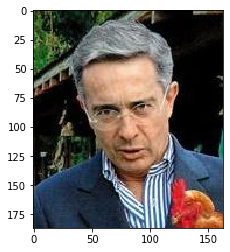

tf.Tensor(b'n009225', shape=(), dtype=string)
b'0263_01.jpg'
Álvaro_Uribe
tf.Tensor(b'm', shape=(), dtype=string)


In [4]:
import tensorflow as tf
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import IPython.display as display
%matplotlib inline

raw_image_dataset = tf.data.TFRecordDataset('/mnt/hdd_raid/datasets/TFRecords/VGGFace2/Test_Raw.tfrecords')

def read_tfrecord(serialized_example):
    image_feature_description = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'depth': tf.io.FixedLenFeature([], tf.int64),
        'class_id': tf.io.FixedLenFeature([], tf.string),
        'sample': tf.io.FixedLenFeature([], tf.string),
        'name': tf.io.FixedLenFeature([], tf.string),
        'gender': tf.io.FixedLenFeature([], tf.string),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(serialized_example, image_feature_description)
    print(type(example))
    
    return example['image_raw'], example['class_id'], example['sample'], example['name'], example['gender']


parsed_image_dataset = raw_image_dataset.map(read_tfrecord)

print(type(parsed_image_dataset))

for image, a, b, c, d in parsed_image_dataset.take(1):
    print(type(image))
    print(type(a))
    image = tf.io.decode_jpeg(image)
    print(type(image))
    plt.imshow(image)
    plt.show()
    print(a)
    print(b.numpy())
    print(c.numpy().decode('UTF-8'))
    print(d)

In [1]:
import tensorflow as tf
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import IPython.display as display
%matplotlib inline

In [2]:
def read_vggface2(serialized_dataset):
    """Parser for the VGGFace2 dataset, saved in TFRecods format.

    Arguments:
        serialized_dataset: dataset from tf.data.TFRecordDataset

    Output:
        MapDataset with shape: `(image_raw, class_id, sample, name, gender)`
    """

    image_feature_description = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'depth': tf.io.FixedLenFeature([], tf.int64),
        'class_id': tf.io.FixedLenFeature([], tf.string),
        'sample': tf.io.FixedLenFeature([], tf.string),
        'name': tf.io.FixedLenFeature([], tf.string),
        'gender': tf.io.FixedLenFeature([], tf.string),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(
        serialized_dataset,
        image_feature_description
    )
    print(type(example['image_raw']))
    return (
        example['image_raw'],
        example['class_id'],
        example['sample'],
        example['name'],
        example['gender']
    )

In [3]:
#raw_image_dataset = tf.data.TFRecordDataset('/mnt/hdd_raid/datasets/TFRecords/VGGFace2/Test_Raw.tfrecords')
raw_image_dataset = tf.data.TFRecordDataset('/mnt/hdd_raid/datasets/TFRecords/MS-Celeb-1M/DeepGlint_Raw.tfrecords')

ds_len = sum(1 for _ in raw_image_dataset)
print('ds_len: {}'.format(ds_len))

parsed_image_dataset = raw_image_dataset.map(read_vggface2)
print(type(parsed_image_dataset))
def preprocess(image):
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    return image

parsed_image_dataset = parsed_image_dataset.map(lambda x, y, z, a, b: (preprocess(x), y, z, a, b))

train_ds = parsed_image_dataset.shuffle(buffer_size=ds_len)

for image_features, class_id, sample, name, gender in train_ds.take(10):

    #image = tf.io.decode_jpeg(image_features)
    #image_raw = image_features['image_raw'].numpy()
    plt.imshow(image)
    plt.show()
    print('Class: {} - Sample: {} - Name: {} - Gender: {}'.format(
        class_id,
        sample,
        name.numpy().decode('UTF-8'),
        gender
    ))

DataLossError: truncated record at 7998148104 [Op:IteratorGetNextSync]